# Getting started with NICER data

## Learning Goals

By the end of this tutorial, you will be able to:
- Download NICER observation data files for a given ObsID.
- Process and clean raw NICER data into "level 2" (science ready) products.
- Extract a spectrum, fit a model to it using PyXspec, and plot the results.
- Extract a light curve, account for good-time-intervals, and plot it.

## Introduction

In this tutorial, we will go through the steps of analyzing a NICER observation (with ObsID 4020180445) of
'PSR B0833-45' using `heasoftpy`.

### Inputs

- The NICER ObsID, 4142010107, of the data we will process (an observation of a pulsar, **PSR B0833-45**).

### Outputs

- Processed NICER "level 2" data files.
- A source and background spectrum.
- A source light curve.
- Fitted spectral model parameters.
- Visualizations of the spectrum and light curve.

### Runtime

As of 19th January 2026, this notebook takes ~6 m to run to completion on Fornax using the 'Default Astrophysics' image and the 'small' server with 8GB RAM/ 2 cores.

## Imports

In [1]:
import contextlib
import os
import shutil

import heasoftpy as hsp
import matplotlib.pyplot as plt
import numpy as np
import xspec as xs
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astroquery.heasarc import Heasarc
from heasoftpy.nicer import nicerl2, nicerl3_lc, nicerl3_spect
from matplotlib.ticker import FuncFormatter
from packaging.version import Version

## Global Setup

### Functions

### Constants

In [2]:
# NICER ObsID that we will use for this example.
OBS_ID = "4020180445"
SRC_NAME = "PSR B0833-45"

# Controls the verbosity of all HEASoftPy tasks
TASK_CHATTER = 3

### Configuration

In [3]:
# ------------- Configure global package settings --------------
# Raise Python exceptions if a heasoftpy task fails
# TODO Remove once this becomes a default in heasoftpy
hsp.Config.allow_failure = False
# --------------------------------------------------------------

# -------------- Set paths and create directories --------------
# Set up the path of the directory into which we will download NICER data
if os.path.exists("../../../_data"):
    ROOT_DATA_DIR = os.path.join(os.path.abspath("../../../_data"), "NICER", "")
else:
    ROOT_DATA_DIR = "NICER/"

# Whatever the data directory is, make sure it is absolute.
ROOT_DATA_DIR = os.path.abspath(ROOT_DATA_DIR)

# Make sure the download directory exists.
os.makedirs(ROOT_DATA_DIR, exist_ok=True)

# Setup path and directory into which we save output files from this example.
OUT_PATH = os.path.abspath("NICER_output")
os.makedirs(OUT_PATH, exist_ok=True)
# --------------------------------------------------------------

# -------- Get geomagnetic data ---------
# This ensures that geomagnetic data required for NICER analyses are downloaded
GEOMAG_PATH = os.path.join(ROOT_DATA_DIR, "geomag")
os.makedirs(GEOMAG_PATH, exist_ok=True)
out = hsp.nigeodown(outdir=GEOMAG_PATH)
# ---------------------------------------

***

## 1. Downloading the NICER data files for 4020180445

We've already decided on the NICER observation we're going to use for this example - as such we don't need an
explorative stage where we use the name of our target, and its coordinates, to find an appropriate observation.

What we do need to know is where the data are stored, and to retrieve a link that we can use to download them - we
can achieve this using the NICER summary table of observations, accessed using `astroquery`.

### Identifying NICER's observation summary (master) table

The name of the observation summary table for NICER can be identified using `Heasarc`, imported from Astroquery. This
command searches for tables with a 'nicer' keyword, and then the `master=True` argument ensures that only
the observation summary table is returned:

In [4]:
catalog_name = Heasarc.list_catalogs(keywords="nicer", master=True)["name"][0]
catalog_name

np.str_('nicermastr')

### Fetching coordinates for the source

A constant containing the name of our source has already been set up in the 'Global Setup: Constants'
subsection near the top of this notebook:

In [5]:
SRC_NAME

'PSR B0833-45'

We can pass the source's name to `from_name()` method of Astropy's `SkyCoord` class to run a name-resolver and retrieve a coordinate:

In [6]:
src_coord = SkyCoord.from_name(SRC_NAME)
src_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (128.83606354, -45.17643181)>

```{note}
Make sure to verify coordinates fetched from name resolving services. You could also set up
a `SkyCoord` object directly if you already know the coordinates of your source.
```

### Finding NICER observations of the region of interest

This demonstration is only going to use a single observation, which we have already chosen, and the ObsID of which
is stored in a constant defined in the 'Global Setup: Constants' subsection near the top of this notebook:

In [7]:
OBS_ID

'4020180445'

We are still going to demonstrate how to use Astroquery to find _all_ NICER observations
of the region of interest (containing our source) however.

In the very first part of _Section 1_ we figured out which HEASARC table contains
summary information about all of NICER's observations, and in the subsection just before
this one we retrieved the coordinates of our source.

We can now put those two pieces together, and use the `Heasarc` object imported from
Astroquery to fetch a table of all NICER observations within a 15$^\prime$ radius of our source.

That search radius is the default for the NICER master table. You can determine the default
search radius of any HEASARC master table by running the following (with your table
name substituted for `catalog_name`):

In [8]:
Heasarc.get_default_radius(catalog_name)

<Quantity 15. arcmin>

In [9]:
nicer_obs = Heasarc.query_region(src_coord, catalog_name)
nicer_obs

name,ra,dec,time,obsid,exposure,processing_status,processing_date,public_date,obs_type,__row
,deg,deg,d,,s,,d,d,,
object,float64,float64,float64,object,float64,object,float64,int32,object,object
PSR_B0833-45,128.84470,-45.18494,60698.342361,7020180451,412.00000,VALIDATED,60710.2772,60712,NOR,14170
PSR_B0833-45,128.84140,-45.18222,58077.706250,1020180135,190.00000,VALIDATED,58182.3529,58181,NOR,14171
PSR_B0833-45,128.83710,-45.18200,60618.025926,7020180437,0.00000,VALIDATED,60629.6769,60632,NOR,14172
PSR_B0833-45,128.84060,-45.18187,60788.170718,8020180407,0.00000,VALIDATED,60799.0997,60802,NOR,14173
PSR_B0833-45,128.84420,-45.18178,58610.253009,2020180319,34.00000,VALIDATED,58613.6425,58624,NOR,14174
PSR_B0833-45,128.83860,-45.18166,60253.678437,6020180429,0.00000,VALIDATED,60264.9452,60267,NOR,14175
PSR_B0833-45,128.83700,-45.18151,59693.049306,5020180407,557.00000,VALIDATED,59704.7151,59707,NOR,14176
PSR_B0833-45,128.83640,-45.18138,60615.060880,7020180434,0.00000,VALIDATED,60625.9445,60629,NOR,14177


```{hint}
You could also specify your own search radius by using `query_region`'s `radius`
argument and passing an Astropy distance quantity.
```

Now we can very easily filter the `nicer_obs` table to select the one ObsID we're interested in:

In [10]:
rel_nicer_obs = nicer_obs[nicer_obs["obsid"] == OBS_ID]
rel_nicer_obs

name,ra,dec,time,obsid,exposure,processing_status,processing_date,public_date,obs_type,__row
,deg,deg,d,,s,,d,d,,
object,float64,float64,float64,object,float64,object,float64,int32,object,object
PSR_B0833-45,128.83640,-45.17660,59475.997465,4020180445,8950.00000,VALIDATED,59487.9267,59490,NOR,14413


#### Constructing an ADQL query [**advanced alternative**]

Alternatively, if we didn't want to use the `query_region` method, we could construct a simple astronomical data query
language (ADQL) query to find the row of the observation summary table that corresponds to our chosen ObsID. This
retrieves every column of the row whose ObsID matches the one we're looking for:

In [11]:
query = (
    "SELECT * "
    "from {c} as cat "
    "where cat.obsid='{oi}'".format(oi=OBS_ID, c=catalog_name)
)

query

"SELECT * from nicermastr as cat where cat.obsid='4020180445'"

The query is then executed, and the returned value is converted to an AstroPy table (necessary for the next step):

In [12]:
rel_nicer_obs = Heasarc.query_tap(query).to_table()
rel_nicer_obs

__row,name,ra,dec,lii,bii,time,end_time,obsid,orig_target_id,target_id,target_ra,target_dec,exposure,time_awarded,mpu0_exposure,mpu1_exposure,mpu2_exposure,mpu3_exposure,mpu4_exposure,mpu5_exposure,mpu6_exposure,num_fpm,processing_status,processing_date,public_date,processing_version,num_processed,caldb_version,software_version,prnb,abstract,subject_category,category_code,pi_lname,pi_fname,cycle,obs_type,title,coordinated,facility,galactic_nh,target_class,remarks,__x_ra_dec,__y_ra_dec,__z_ra_dec
,,deg,deg,deg,deg,d,d,,,,deg,deg,s,s,s,s,s,s,s,s,s,,,d,d,,,,,,,,,,,,,,,,1 / cm2,,,,,
object,object,float64,float64,float64,float64,float64,float64,object,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,object,float64,int32,object,int16,object,object,object,object,object,int16,object,object,int16,object,object,int16,object,float64,object,object,float64,float64,float64
14413,PSR_B0833-45,128.83640,-45.17660,263.55224,-2.78717,59475.997465,59476.980984,4020180445,1410,-1,128.83606,-45.17643,8950.00000,0.00000,12339.00000,12339.00000,12340.00000,12338.00000,12338.00000,12338.00000,12339.00000,49,VALIDATED,59487.9267,59490,l0-master_20210902,7,xti20210707,Hea_31Aug2021_V6.29c_NICER_2021-08-31_V008c,4020,Observations dedicated to the Magnetar science working group,MAGNETAR,2,GENDREAU,KEITH C.,4,NOR,MAGNETAR WORKING GROUP,--,,1e+16,,,0.549093264741745,-0.442056958635063,-0.709282899792156


### Downloading the NICER observation data files

Identifying the 'data link' that we need to download the data files is now as simple
as passing the query return to the `locate_data` method of `Heasarc`:

In [13]:
data_links = Heasarc.locate_data(rel_nicer_obs, catalog_name)
data_links

ID,access_url,sciserver,aws,content_length,error_message
,,,,byte,
object,object,str39,str52,int64,object
ivo://nasa.heasarc/nicermastr?14413,https://heasarc.gsfc.nasa.gov/FTP/nicer/data/obs/2021_09//4020180445/,/FTP/nicer/data/obs/2021_09/4020180445/,s3://nasa-heasarc/nicer/data/obs/2021_09/4020180445/,1090157605,


This data link can be passed straight into the `download_data` method of `Heasarc`, and our observation data files
will be downloaded into the directory specified by `ROOT_DATA_DIR`.

In [14]:
# Heasarc.download_data(data_links, host="sciserver", location=ROOT_DATA_DIR)
Heasarc.download_data(data_links, host="aws", location=ROOT_DATA_DIR)

# We remove the existing cleaned event list directory from the data we just downloaded
shutil.rmtree(os.path.join(ROOT_DATA_DIR, OBS_ID, "xti", "event_cl"))

INFO: Downloading data AWS S3 ... [astroquery.heasarc.core]
INFO: Enabling anonymous cloud data access ... [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/nicer/data/obs/2021_09/4020180445/ [astroquery.heasarc.core]


INFO: downloading s3://nasa-heasarc/nicer/data/obs/2021_09/4020180445/ [astroquery.heasarc.core]


## 2. Preparing the NICER observation

### HEASoft and HEASoftPy versions

```{warning}
There is an issue with some HEASoft releases prior to **v6.35.2** where output
event list file names all erroneously contain '$EVTSUFFIX', which causes subsequent
processing steps to fail. This subsection includes a workaround for this issue.
```

Both the HEASoft and HEASoftPy package versions can be retrieved from the
HEASoftPy module.

The HEASoftPy version:

In [15]:
hsp.__version__

'1.5'

The HEASoft version:

In [16]:
fver_out = hsp.fversion()
fver_out

---------------------
:: Execution Result ::
---------------------
> Return Code: 0
> Output:
26Sep2025_V6.36

> Parameters:
	version   : $( )
	mode      : ql

For versions of HEASoft older than **v6.36** we have to manually set an `evtsuffix` in
order to ensure that the output event list filenames are correct. First though, we have
to identify which version of HEASoft we're using by extracting the version string from
the `fversion` output, and setting up a `Version` object:

In [17]:
fver_out.output[0].split("_")[-1]
HEA_VER = Version(fver_out.output[0].split("_")[-1])
HEA_VER

<Version('6.36')>

We can now check whether `HEA_VER` is lower than the minimum required version. If the
version is too low, we set the `evt_suffix` variable to `_demo`, otherwise we
set it to the default value:

In [18]:
if HEA_VER < Version("v6.36"):
    evt_suffix = "_demo"
else:
    evt_suffix = "NONE"

### Processing and cleaning the raw NICER data

Next up, we're going to run the `nicerl2` pipeline to process and clean the raw NICER data; this will render it
ready for scientific use. NICER pipelines are implemented in HEASoft, and as such we can make use of interfaces
built into HEASoftPy to run them in this notebook, rather than in the command line.

This pipeline is designed to produce "level 2" data products and includes steps for standard calibration,
screening, and filtering of data. The outputs are an updated filter file and a cleaned event list.

***It is worth applying `nicerl2` to any observation that you know was last processed with an older calibration!***

```{note}
The `filtcolumns` argument to `nicerl2` will default to the latest version of the standard columns (V6 as of the
20th October 2025). You may also set it manually (as we do here) for backwards compatibility reasons - see the
'Selecting filter file columns' section of [the nicerl2 help file](https://heasarc.gsfc.nasa.gov/docs/software/lheasoft/help/nicerl2.html) for more information.
```

In [19]:
OBS_ID_PATH = os.path.join(ROOT_DATA_DIR, OBS_ID)

# Run the task
out = nicerl2(
    indir=OBS_ID_PATH,
    geomag_path=GEOMAG_PATH,
    filtcolumns="NICERV5",
    evtsuffix=evt_suffix,
    clobber=True,
    noprompt=True,
    chatter=TASK_CHATTER,
)

```{warning}
NICER level-2 processing now **requires** up-to-date geomagnetic data
([see this for a discussion](https://heasarc.gsfc.nasa.gov/docs/nicer/analysis_threads/geomag/)); we used a HEASoftPy
tool (`nigeodown`) to download the latest geomagnetic data in the 'Global setup: Configuration' section near the top of
this notebook.
```

## 3. Extracting a spectrum from the processed data

Now that the raw data are processed into "level 2" products and are ready for scientific use, we will use the
`nicerl3-spect` pipeline (part of HEASoft, and available for use through HEASoftPy) to extract a spectrum of our source.

```{important}
The `nicerl3-spect` tool is only available in HEASoft v6.31 or later.
```

For this example, we use the `scorpeon` model to create a background spectrum. Other background models are implemented
in the `nicerl3-spect` tool, and can be selected using the `bkgmodeltype` argument (see the 'background estimation'
section of [the nicerl3-spect help file](https://heasarc.gsfc.nasa.gov/docs/software/lheasoft/help/nicerl3-spect.html) for more information).

The source and background spectra are written to the OUT_PATH directory we set up in the collapsed 'Global Setup: Configuration' subsection above.

Note that we set the parameter `updatepha` to `yes`, so that the header of the spectral file is modified to point to the matching response and background files.

In [20]:
# The contextlib.chdir context manager is used to temporarily change the working
#  directory to the directory where the output files will be written.
with contextlib.chdir(OUT_PATH):

    # Run the spectral extraction task
    out = nicerl3_spect(
        indir=OBS_ID_PATH,
        phafile="spec.pha",
        rmffile="spec.rmf",
        arffile="spec.arf",
        bkgfile="spec_sc.bgd",
        evtsuffix=evt_suffix,
        grouptype="optmin",
        groupscale=5,
        updatepha="yes",
        bkgformat="file",
        bkgmodeltype="scorpeon",
        clobber=True,
        noprompt=True,
        chatter=TASK_CHATTER,
    )

```{note}
Note that the **-** symbol in the pipeline name is replaced by **_** (underscore) when calling through
HEASoftPy; `nicerl3-spect3` becomes `nicerl3_spect3`.
```

## 4. Extracting a light curve from the processed data

We also might want to see how the intensity of our source changes with time (something that NICER is particularly well suited for).

As such, we use the `nicerl3-lc` (again only available in HEASoft v6.31 or later) tool to extract a light curve for our source (though this process **does not** extract an accompanying background light curve).

In [21]:
# Extract light curve
with contextlib.chdir(OUT_PATH):
    # Run the light curve task
    out = nicerl3_lc(
        indir=OBS_ID_PATH,
        timebinsize=10,
        lcfile="lc.fits",
        evtsuffix=evt_suffix,
        clobber=True,
        noprompt=True,
        chatter=TASK_CHATTER,
    )

## 5. Visualization and analysis of freshly-generated data products

Now we can put our recently extracted spectrum and light curve to use!

### Spectral analysis
Here we will go through a simple demonstration of how the spectrum we just extracted can be analyzed using `PyXspec`.

We're going to use the Python interface to XSPEC (PyXspec) to perform a simple spectral analysis of our NICER spectrum.

#### Configuring PyXspec

Here we configure some of PyXspec's behaviors. We set the verbosity to '0' to suppress printed output, make sure the
plot axes are energy (for the x-axis), and normalized counts per second (for the y-axis).

In [22]:
xs.Xset.chatter = 0

# Other xspec settings
xs.Plot.area = True
xs.Plot.xAxis = "keV"
xs.Plot.background = True
xs.Fit.query = "no"

#### Loading the spectrum

To load our spectrum into PyXspec, we just have to declare a Spectrum object and point it to the "spec.pha" file we just
generated.

In [23]:
with contextlib.chdir(OUT_PATH):
    xs.AllData.clear()
    spec = xs.Spectrum("spec.pha")

We make sure to exclude any channels with energies that fall outside the nominal energy range of NICER's detectors:

In [24]:
spec.ignore("0.0-0.3, 10.0-**")

#### Fitting a model to the spectrum

We're going to fit a simple model to our spectrum; a galactic-hydrogen-column-absorbed broken powerlaw (meaning it
has two different photon indexes, and a transition energy between the two powerlaws they describe).

Once the model is defined, we move straight to performing the fit, rather than setting up any particularly physically motivated
start parameters. **This is not necessarily something that we recommend for your analysis**, but it can be a good way
to start exploring your data.

Then we use the `Plot` instance to set up a plot with normalized counts per second on the y-axis (plotted on a
linear scale) - recall that we already set the x-axis to be energy in a previous step.

In [25]:
# Fit a simple absorbed broken powerlaw model
model = xs.Model("wabs*bknpow")
xs.Fit.perform()

# Read out the plotting information for spectrum and model.
xs.Plot("ldata")
# The y-axis values/errors of the observed spectrum (normalized by response)
norm_cnt_rates = xs.Plot.y()
norm_cnt_rates_err = xs.Plot.yErr()

# The energy bins of the observed spectrum
en = xs.Plot.x()
en_cents = xs.Plot.x()
en_widths = xs.Plot.xErr()

# And the model y-values
model = xs.Plot.model()

#### Examining the fit parameters

Using the `show()` method of PyXspec's AllModels class, we can examine the fitted parameters of the model. As the
show method is also affected by our configuration of chatter level, we briefly increase PyXspec's verbosity
in order to see an output.

In [26]:
xs.Xset.chatter = 10
xs.AllModels.show()
xs.Xset.chatter = 0

Creating a $HOME/.xspec directory for you

Parameters defined:
Model wabs<1>*bknpower<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   wabs       nH         10^22    3.83005E-02  +/-  2.10721E-03  
   2    2   bknpower   PhoIndx1            2.40219      +/-  2.67759E-02  
   3    2   bknpower   BreakE     keV      1.31037      +/-  1.80388E-02  
   4    2   bknpower   PhoIndx2            1.61842      +/-  8.99879E-03  
   5    2   bknpower   norm                1.77091E-02  +/-  1.18084E-04  
________________________________________________________________________


   1    1   wabs       nH         10^22    3.83005E-02  +/-  2.10721E-03  
   2    2   bknpower   PhoIndx1            2.40219      +/-  2.67759E-02  
   3    2   bknpower   BreakE     keV      1.31037      +/-  1.80388E-02  
   4    2   bknpower   PhoIndx2            1.61842      +/-  8.99879E-03  
   5    2   bknpower   norm                1.77091E-02  +/-  1.18084E-04  
________________________________________________________________________



### Visualizing the fitted spectrum

As we made sure to extract the data required to plot the spectrum from PyXspec, we can use `matplotlib` to make a nice
visualization - this offers a little more flexibility than using PyXspec directly, but that is also an option!

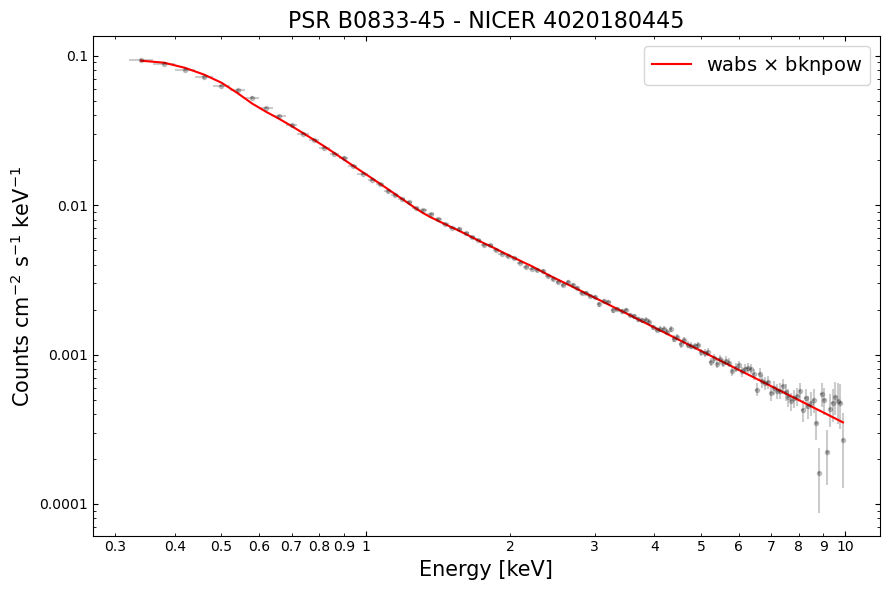

In [27]:
# Plot the spectra
fig = plt.figure(figsize=(9, 6))
plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

plt.errorbar(
    en_cents,
    norm_cnt_rates,
    xerr=en_widths,
    yerr=norm_cnt_rates_err,
    fmt="k.",
    alpha=0.2,
)
plt.plot(en_cents, model, "r-", label=r"wabs $\times$ bknpow")

plt.title("{n} - NICER {o}".format(n=SRC_NAME, o=OBS_ID), fontsize=16)

plt.yscale("log")
plt.xscale("log")

plt.gca().xaxis.set_minor_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

plt.xlabel("Energy [keV]", fontsize=15)
plt.ylabel(r"Counts cm$^{-2}$ s$^{-1}$ keV$^{-1}$", fontsize=15)

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

### Making a visualization of the NICER light curve

We previously generated a light curve for our source from our chosen NICER observation. Now we're going to read
the information in the light curve file into memory, prepare it, and then plot it. This process will highlight the
importance of good-time-intervals (GTI) in NICER observations.

For the loading of the light curve file, we're just going to use the `astropy.io.fits` module, rather than a
specialized tool designed for light curve analysis (such as [the `Stingray` Python module](https://docs.stingray.science/en/stable/)).

The following information will be extracted:
- **TIMEDEL** - The timing resolution of the light curve (stored in the header).
- **TIMEZERO** - _In every case, TIMEZERO must be added to the TIME column to get the true time value_ (stored in the header).
- **RATE FITS table** - The FITS table containing the count rate, time, and fractional exposure information (i.e., light curve data points).
- **GTI FITS table** - Another FITS table that defines the good-time-intervals (GTI) for the light curve.

```{hint}
Given the importance of accurate event timing for many of NICER's science use cases, there is [an article dedicated to explaining the timing system](https://heasarc.gsfc.nasa.gov/docs/nicer/analysis_threads/time/) implemented in NICER data products.
```

#### Reading the light curve file

Reading and preparing the light curve file is a simple process, requiring only a few basic steps. Some information is
read out of the FITS file header, whereas some are whole FITS tables. Note that we add the TIMEZERO value to the
TIME column of the light curve data points, which converts them from a time relative to the beginning of the
observation to an absolute timescale.

In [28]:
with fits.open(os.path.join(OUT_PATH, "lc.fits")) as fp:
    # Reading reference values that help define the light curves
    #  timing system from the FITS header
    time_bin = fp["rate"].header["timedel"]
    time_zero = fp["rate"].header["timezero"]

    # Reading out the whole light curve table (contains data to plot the light curve)
    lc_table = Table(fp["rate"].data)
    lc_table["TIME"] += time_zero

    # Getting the good-time-intervals table as well, to help with plotting
    gti_table = Table(fp["gti"].data)

We can briefly examine the contents of the light curve table:

In [29]:
lc_table

TIME,RATE,ERROR,FRACEXP,NUM_FPM_SEL
float64,float32,float32,float32,float32
243475183.0,57.980362,1.532714,0.93,46.0
243475213.0,60.628986,1.5114796,1.0,46.0
243475243.0,58.028984,1.4787154,1.0,46.0
243475273.0,56.747826,1.4623009,1.0,46.0
243475303.0,55.278263,1.4432425,1.0,46.0
243475333.0,55.692753,1.4486434,1.0,46.0
243475363.0,54.63768,1.4348557,1.0,46.0
243475393.0,57.275364,1.469082,1.0,46.0
243475423.0,57.086956,1.4666638,1.0,46.0


#### Showing the **whole** light curve

The first way we look at this light curve is to plot every data point as is. This will highlight the importance
of GTIs in NICER observations, as well as showing us that a slightly more sophisticated visualization is required
to make the resulting figure actually useful.

As NICER is mounted on the ISS, which is in a low and fast orbit around the Earth, it cannot be pointed at one
patch of sky for very long. Limited pointing times means that to get a useful exposure on a target, the observation
is split into multiple parts, with sizeable time intervals between them. This characteristic is also seen in all sky
survey data taken by ROSAT and eROSITA.

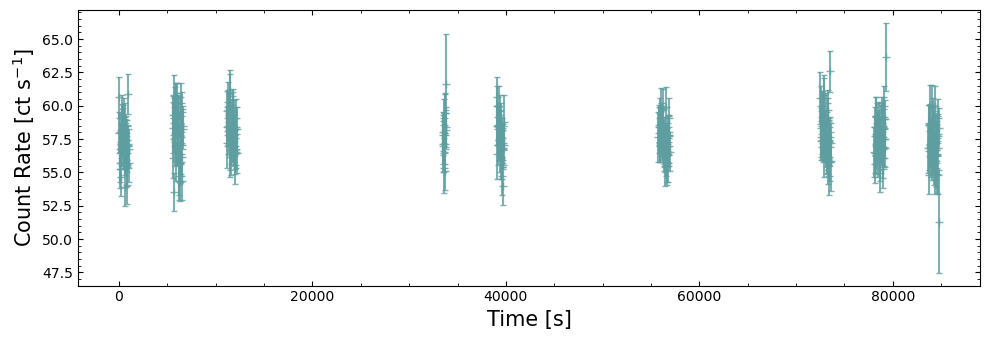

In [30]:
plt.figure(figsize=(10, 3.5))
plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

plt.errorbar(
    lc_table["TIME"] - time_zero,
    lc_table["RATE"],
    yerr=lc_table["ERROR"],
    fmt="+",
    capsize=2,
    color="cadetblue",
    alpha=0.8,
)

plt.xlabel("Time [s]", fontsize=15)
plt.ylabel("Count Rate [ct s$^{-1}$]", fontsize=15)

plt.tight_layout()
plt.show()

#### Showing **only the GTIs** of the light curve

The pre-defined GTI table packaged with the light curve tells us which portions of the overall observation time window
are valid for our target. Using this, we can extract only those time windows that are relevant to us and thus
re-imagine the above figure in a way that is much more useful.

Here we cycle through the GTI tables and double-check that they are fully within the observation time window:

In [31]:
valid_gtis = []
for cur_gti in gti_table:
    gti_check = (lc_table["TIME"] - time_bin / 2 >= cur_gti["START"]) & (
        lc_table["TIME"] + time_bin / 2 <= cur_gti["STOP"]
    )
    if np.any(gti_check):
        valid_gtis.append(gti_check)

Now we can plot only the parts of the observation light curve that are populated with data; there are various ways
to present this data, and longer observations with more GTIs become increasingly difficult to visualize effectively.

Our demonstration then is a fairly simple solution, but it is effective for this observation.

Note that when we set up the figure and its subplots, we use the `sharey=True` argument to make sure each GTI's
data is plotted on the same count-rate scale. We have also reduced horizontal separation between subplots to zero, by
calling `fig.subplots_adjust(wspace=0)` - this cannot be used in combination with `plt.tight_layout()`, so when saving
the figure we pass `bbox_inches="tight"` to reduce white space around the edges of the plot.

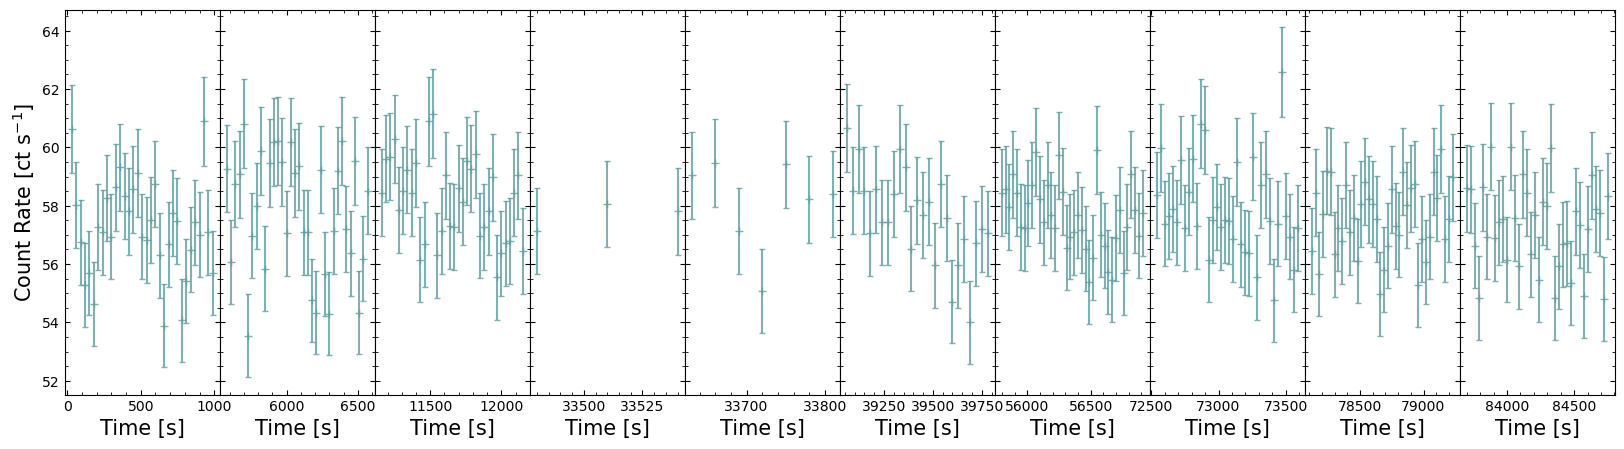

In [32]:
num_gti = len(valid_gtis)

fig, ax_arr = plt.subplots(1, num_gti, figsize=(2 * num_gti, 5), sharey=True)
fig.subplots_adjust(wspace=0)

for cur_gti_ind, cur_gti in enumerate(valid_gtis):
    ax = ax_arr[cur_gti_ind]

    cur_lc_tab = lc_table[cur_gti]

    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True)
    ax.errorbar(
        cur_lc_tab["TIME"] - time_zero,
        cur_lc_tab["RATE"],
        yerr=cur_lc_tab["ERROR"],
        fmt="+",
        capsize=2,
        color="cadetblue",
        alpha=0.8,
    )

    ax.set_xlabel("Time [s]", fontsize=15)

    # We only want to add a y-axis label to the left-most subplot
    if cur_gti_ind == 0:
        ax.set_ylabel("Count Rate [ct s$^{-1}$]", fontsize=15)

# Saving the figure to a PDF
plt.savefig(
    "{n}-nicer-gti-lightcurve.pdf".format(n=SRC_NAME.replace(" ", "")),
    bbox_inches="tight",
)

plt.show()

## About this notebook

Author: Mike Corcoran, Associate Research Professor

Author: Abdu Zoghbi, HEASARC Staff Scientist

Author: David Turner, HEASARC Staff Scientist

Updated On: 2026-01-19

### Additional Resources

Support: [NICER GOF Helpdesk](https://heasarc.gsfc.nasa.gov/cgi-bin/Feedback)

Documents:

- **NICER timing guide** - [https://heasarc.gsfc.nasa.gov/docs/nicer/analysis_threads/time/](https://heasarc.gsfc.nasa.gov/docs/nicer/analysis_threads/time/)
- **Geomagnetic quantities for NICER** - [https://heasarc.gsfc.nasa.gov/docs/nicer/analysis_threads/geomag/](https://heasarc.gsfc.nasa.gov/docs/nicer/analysis_threads/geomag/)

### Acknowledgements

### References